# Analysis file
First created by Vincent Belpaire.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import locale

locale.setlocale(locale.LC_ALL, 'de_DE')

'de_DE'

### Magneet veld

## Reading in the data

Remark all data was measured in mV!!! The data sampling took place with a sampling time of 10ms.

In [2]:
# These functions will be used to load in particular data files

def file(Bi, Aj, metal='', folder="data/"):
    filename = ''
    if metal == 'T':
        filename += 'T'
    filename += 'B' + str(Bi) + 'A' + str(Aj) + '.txt'
    return folder + filename

def read_data(file):
    with open(file, 'r') as infile:
        rawdata = infile.read()
        data = np.array([x.split(': ')[-1][:-3] for x in rawdata.split('\n')][1:-1]).astype(float) # exclude first and last data sample because they are not always complete
    infile.close()
    return data

## Data analysis

In [3]:
Ts = 1 # s (sampling periode) used delay was 100ms
Fs = 1/Ts # Hz (sampling frequency)

In [25]:
def plot_hall(ax,x,y,B,I):
    ax.plot(x,y)
    ax.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:#.2n}'))
    ax.set_xlabel('Sample')
    ax.set_ylabel('Spanning (mV)')
    ax.set_title(f'Magneetveldsterkte: {B} mT, Stroom: {I} A')

def plot_fft(ax,x,y,B,I):
    ax.plot(x,y)
    ax.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:#.2n}'))
    ax.set_xlabel('frequentie (Hz)')
    ax.set_ylabel('Spanning (mV)')
    ax.set_title(f'Magneetveldsterkte: {B} mT, Stroom: {I} A')    

def plot_hall_mean(ax, U1_mean, U2_mean, U3_mean, t1_interval, t2_interval, t3_interval, B, I):
    # Plotting horizontal lines
    ax.plot(t1_interval, [U1_mean, U1_mean], color='red')
    ax.plot(t2_interval, [U2_mean, U2_mean], color='red')
    ax.plot(t3_interval, [U3_mean, U3_mean], color='red')
    ax.plot(t3_interval, [U2_mean, U2_mean], linestyle='--', color='black')

    # Plotting vertical lines
    ax.plot([t1_interval[-1], t1_interval[-1]], [U1_mean, U2_mean], color='red')
    ax.plot([t2_interval[-1], t2_interval[-1]], [U2_mean, U3_mean], color='red')

    # Plotting the vertical line that indicates the difference between U2 and U3
    t_line = t3_interval[0] + (t3_interval[1] - t3_interval[0]) / 2
    
    # Adding arrows at the ends
    ax.annotate('', xy=(t_line, U2_mean), xytext=(t_line, U2_mean - (U2_mean - U3_mean)),
                 arrowprops=dict(facecolor='black', arrowstyle='<|-|>', linewidth=0.5))

    # Adding U_H
    ax.text(t_line + 0.5, abs(U2_mean - (U2_mean - U3_mean) / 2), f'$U_H = {round(abs(U2_mean - U3_mean)*(10**6), 2)}$ nV', fontsize=10, color='black')

    ax.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:#.2n}'))
    ax.set_xlabel('Sample')
    ax.set_ylabel('Spanning (mV)')
    ax.set_title(f'Magneetveldsterkte: {B} mT, Stroom: {I} A') 
    

In [5]:
# Gives n with standard error in 1/cm^3, you need to give all values in SI units
def get_n_with_std(I, B, U_H, b, h, l2, e):
    n = ((I[0] * B[0] * l2[0]) / (b[0] * h[0] * U_H[0] * e)) * (10**-6)
    n_std = n * (((I[1]/I[0])**2 + (B[1]/B[0])**2 + (b[1]/b[0])**2 + (h[1]/h[0])**2 + (U_H[1]/U_H[0])**2 + (l2[1]/l2[0])**2) ** 0.5)
    
    return (abs(n), abs(n_std))

### 1. Koper

#### Omhse effecten

De databestanden met 'B0' in hun bestandsnaam werden gemaakt om de Ohmse effecten die eventueel aanwezig zouden zijn in het circuit te kunnen bestuderen. Deze informatie kan later gebruikt zijn om de data te "corrigeren" op deze effecten.

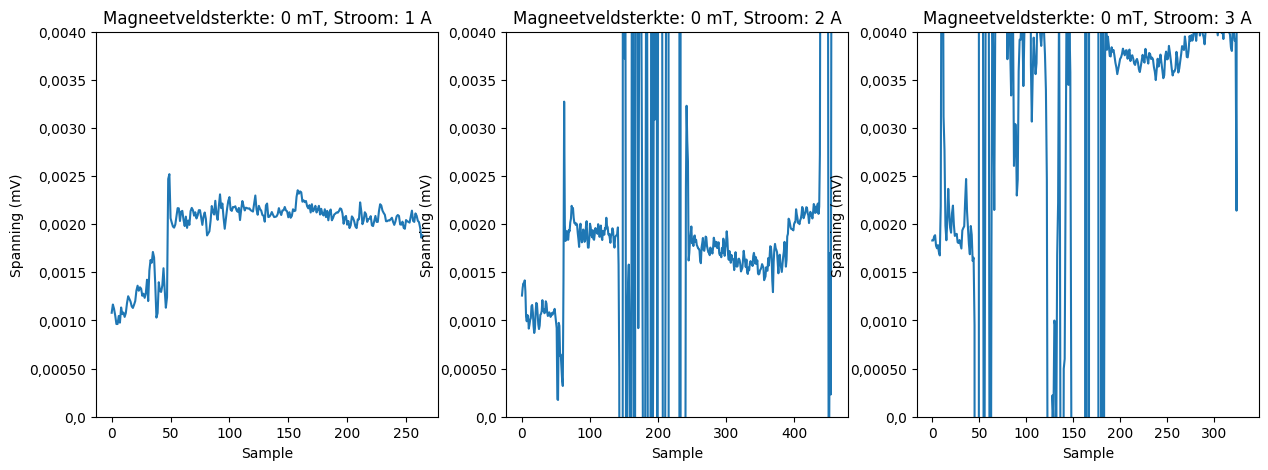

In [31]:
B = 0
A = [1,2,3]

fig, ax = plt.subplots(ncols=3,figsize=(15,5))

for i in range(3):

    x = read_data(file(B,A[i]))
    N = len(x)
    t = Ts*np.arange(N)
    plot_hall(ax[i],t,x,B,A[i])
    ax[i].set_ylim(0,0.004)



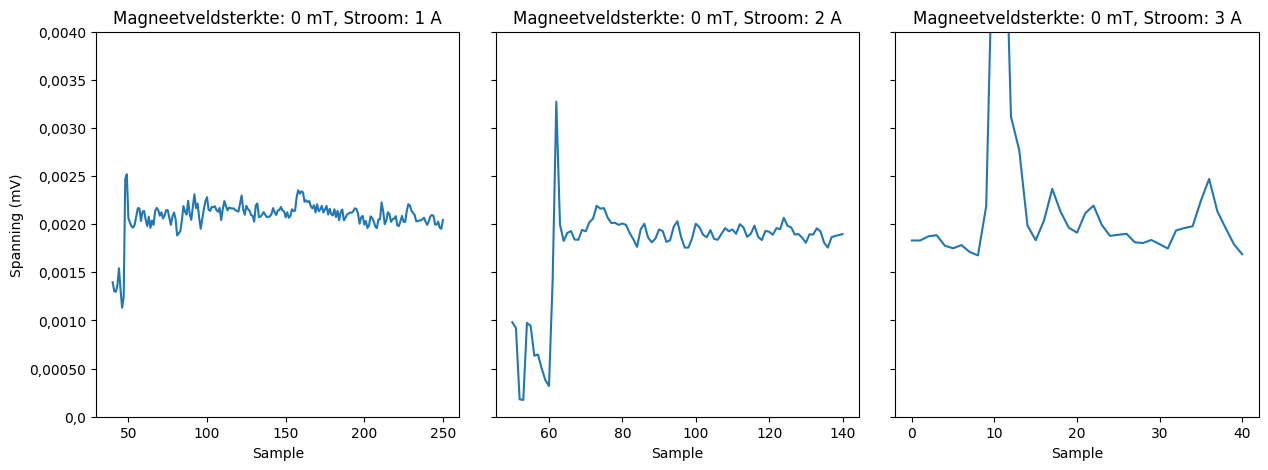

In [33]:
# aanpassen van de time window

fig, ax = plt.subplots(ncols=3,figsize=(15,5),sharey=True)
plt.subplots_adjust(wspace=0.1)
Tmin,Tmax = [40,50,0],[250,140,40]
#Tmin = [0,0,0]

for i in range(3):

    x = read_data(file(B,A[i]))
    N = len(x)
    t = Ts*np.arange(N)
    tmin,tmax = Tmin[i],Tmax[i]
    plot_hall(ax[i],t[np.logical_and(tmin <= t, t <= tmax)],x[np.logical_and(tmin <= t, t <= tmax)],B,A[i])
    ax[i].set_ylim(0,0.004)
    if i > 0:
        ax[i].set_ylabel(None)

In de figuur voor B0A1 zien we duidelijk de sprong wanneer de stroom wordt aangezet. In de andere figuren is dit moeilijker te zien doordat er zeer grote ruispieken op te zien zijn. Wellicht heeft dit te maken door bewegingen van het circuit. Bij het collecteren van de data voor deze laaste twee figuren werd het magneet op het einde toegevoeg. Dit veroorzaakte wellicht veel beweging en dus ook ruis. 

Over ruis gesproken. We zien een oscillatie verschijnsle terug in de data. Met behulp van een Fourier analyse kan deze ruis misschien worden verwijderd.

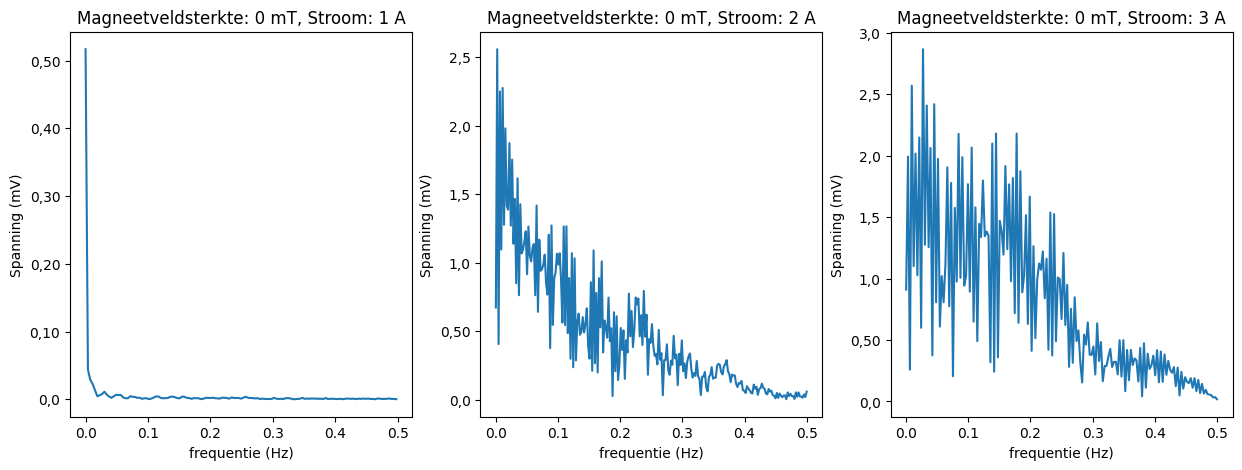

In [8]:
fig, ax = plt.subplots(ncols=3,figsize=(15,5))

for i in range(3):

    x = read_data(file(B,A[i]))
    N = len(x)
    t = Ts*np.arange(N)
    X = np.abs(np.fft.rfft(x))
    f = Fs*np.fft.rfftfreq(len(x))
    plot_fft(ax[i],f,X,B,A[i])

0.00212531676056338 (0.002095798472222222+0j) 8.125316440684491e-05
0.0019249445070422533 (0.001898209166666667+0j) 9.056819935615454e-05
0.0019494694444444443 (0.0017545225000000003+0j) 0.00013743911902577177


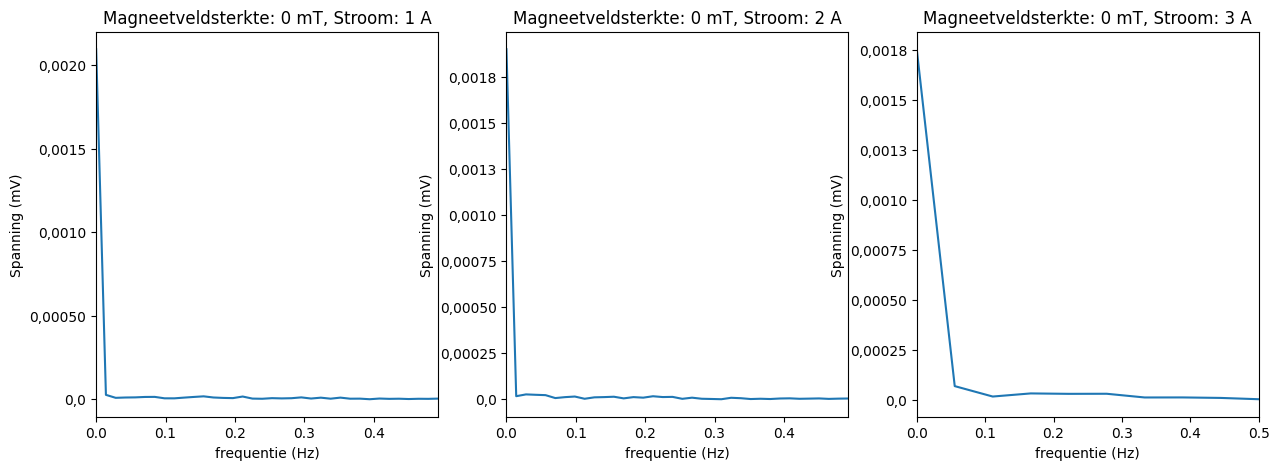

In [9]:
# aanpassen van de window

fig, ax = plt.subplots(ncols=3,figsize=(15,5))

for i in range(3):

    x = read_data(file(B,A[i]))
    N = len(x)
    t = Ts*np.arange(N)
    if i != 2:
        tmin,tmax = 70,140
    else:
        tmin, tmax = 18, 35
    X = np.fft.rfft(x[np.logical_and(tmin <= t, t <= tmax)])
    f = Fs*np.fft.rfftfreq(len(x[np.logical_and(tmin <= t, t <= tmax)]))
    fmin,fmax = 0,max(f)
    AX = np.abs(X)/(2*len(X))
    plot_fft(ax[i],f[np.logical_and(fmin <= f, f <= fmax)],AX[np.logical_and(fmin <= f, f <= fmax)],B,A[i])
    ax[i].set_xlim(fmin,fmax)
    print(np.mean(x[np.logical_and(tmin <= t, t <= tmax)]),X[0]/(2*len(X)), np.std(x[np.logical_and(tmin <= t, t <= tmax)]))

Het is nog niet direct duidelijk om uit dit een correctie term te vinden. Eventueel zou je de correctie uit kunnen voeren in het frequentie domein maar eenvoudiger zou het zijn om correcties toe te passen op berekende gemiddelde. Laten we nu alle data verzamelen behorden tot de stromen 1A,2A en 3A voor koper waarbij er geen magneet aanwezig was.

In [10]:
# Alles voor 0A

x = read_data(file(0,A[0]))
N = len(x)
t = Ts*np.arange(N)
x = x[np.logical_and(0 <= t, t <= 40)]
V = x
I = np.zeros(len(x))

x = read_data(file(0,A[0]))
N = len(x)
t = Ts*np.arange(N)
x = x[np.logical_and(0 <= t, t <= 40)]
V = np.concatenate((V,x))
I = np.concatenate((I,np.zeros(len(x))))

# Alles voor 1A

x = read_data(file(0,A[0]))
N = len(x)
t = Ts*np.arange(N)
x = x[np.logical_and(50 <= t, t <= np.max(t))]
V = np.concatenate((V,x))
I = np.concatenate((I,np.ones(len(x))))

# Alles voor 2A

x = read_data(file(0,A[1]))
N = len(x)
t = Ts*np.arange(N)
x = x[np.logical_and(70 <= t, t <= 140)]
V = np.concatenate((V,x))
I = np.concatenate((I,2*np.ones(len(x))))

# Alles voor 3A

x = read_data(file(0,A[2]))
N = len(x)
t = Ts*np.arange(N)
x = x[np.logical_and(20 <= t, t <= 40)]
V = np.concatenate((V,x))
I = np.concatenate((I,3*np.ones(len(x))))

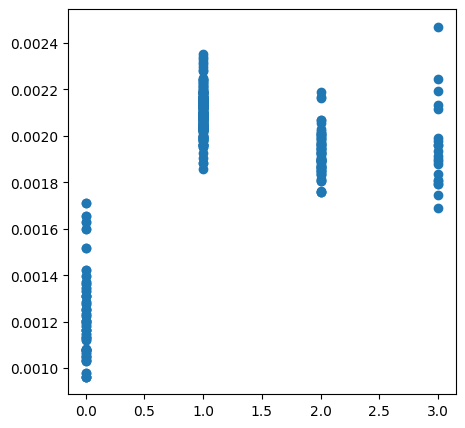

In [11]:
fig, ax = plt.subplots(figsize=(5,5))

ax.scatter(I,V)

#### Hall spanning

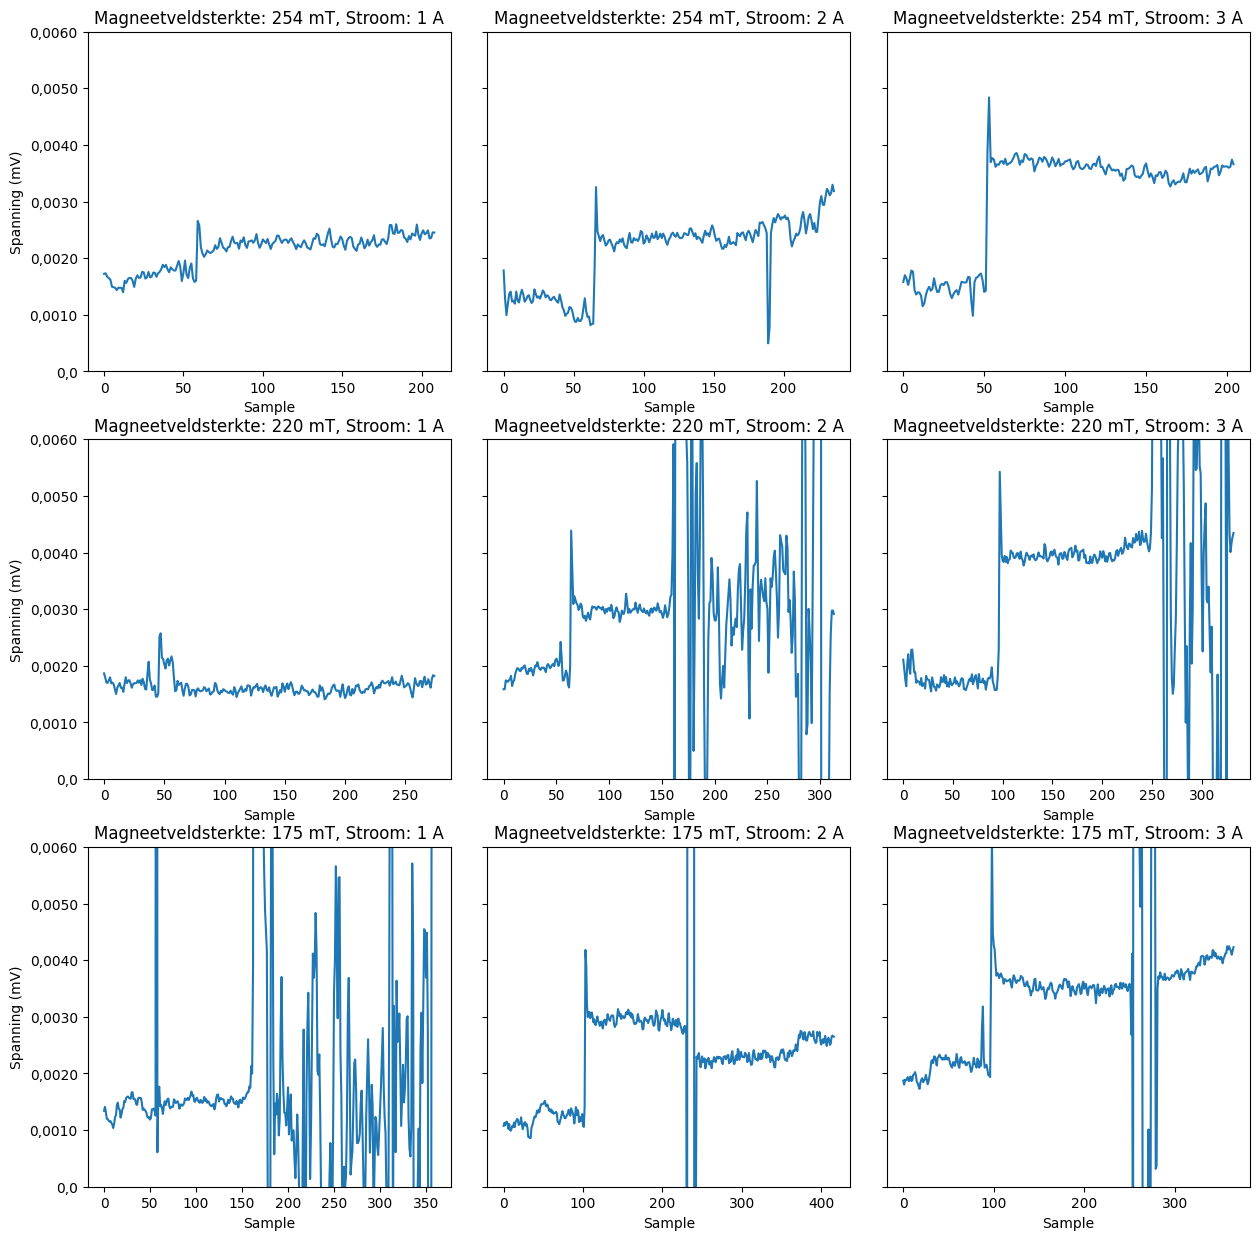

In [29]:
B = [254,220,175] # mT
A = np.array([1,2,3]) # A

fig, ax = plt.subplots(nrows=3,ncols=3,figsize=(15,15), sharey=True)
plt.subplots_adjust(wspace=0.1)

for i in range(3):
    for j in range(3):

        x = read_data(file(B[j],A[i]))
        N = len(x)
        t = Ts*np.arange(N)
        plot_hall(ax[j,i],t,x,B[j],A[i])
        ax[j,i].set_ylim(0,0.006)
        if i != 0:
            ax[j,i].set_ylabel(None)

#### B = 254 mT
Laten we om te starten enkel de drie metingen nemen met magneetveldsterkte van 254 mT. We houden ons tot de samples tussen 60 en 150 (voor $U_2$).

Met: $U_H = U_2 - U_3$ en $\sigma (U_H) = \sqrt{\sigma ^2 (U_2) + \sigma ^2 (U_3)}$

In [13]:
B = 254
I = np.array([1, 2, 3])

U_1 = np.zeros(3)
U_1_STD = np.zeros(3)

U_2 = np.zeros(3)
U_2_STD = np.zeros(3)

U_3 = np.array([0.0021234310526315786, 0.0019227517105263154, 0.002668906842105263])
U_3_STD = np.array([8.125316440684491e-05, 9.056819935615454e-05, 0.00013743911902577177])

U_H = np.zeros(3)
U_H_STD = np.zeros(3)


for i in range(3):
    x = read_data(file(B,A[i]))
    N = len(x)
    t = Ts*np.arange(N)
    
    U_1[i] = np.mean(x[np.logical_and(10 < t, t < 40)])
    U_1_STD[i] = np.std(x[np.logical_and(10 < t, t < 40)])

    U_2[i] = np.mean(x[np.logical_and(60 < t, t < 150)])
    U_2_STD[i] = np.std(x[np.logical_and(60 < t, t < 150)])
     
    U_H[i] = U_2[i] - U_3[i] #np.mean(x[np.logical_and(0 < t, t < 50)])
    U_H_STD[i] = (U_2_STD[i] ** 2 + U_3_STD[i] ** 2) ** 0.5

In [14]:
print(U_H)
print(U_H_STD)

[0.00013613 0.00037386 0.0009752 ]
[0.00012177 0.00035145 0.0001737 ]


Dus we zien dat: 

$U_{H1} = (0,00014 \pm 0,00013)$ mV; $U_{H2} = (0,00036 \pm 0,00036)$ mV; $U_{H3} = (0,00098 \pm 0,00018)$ mV.

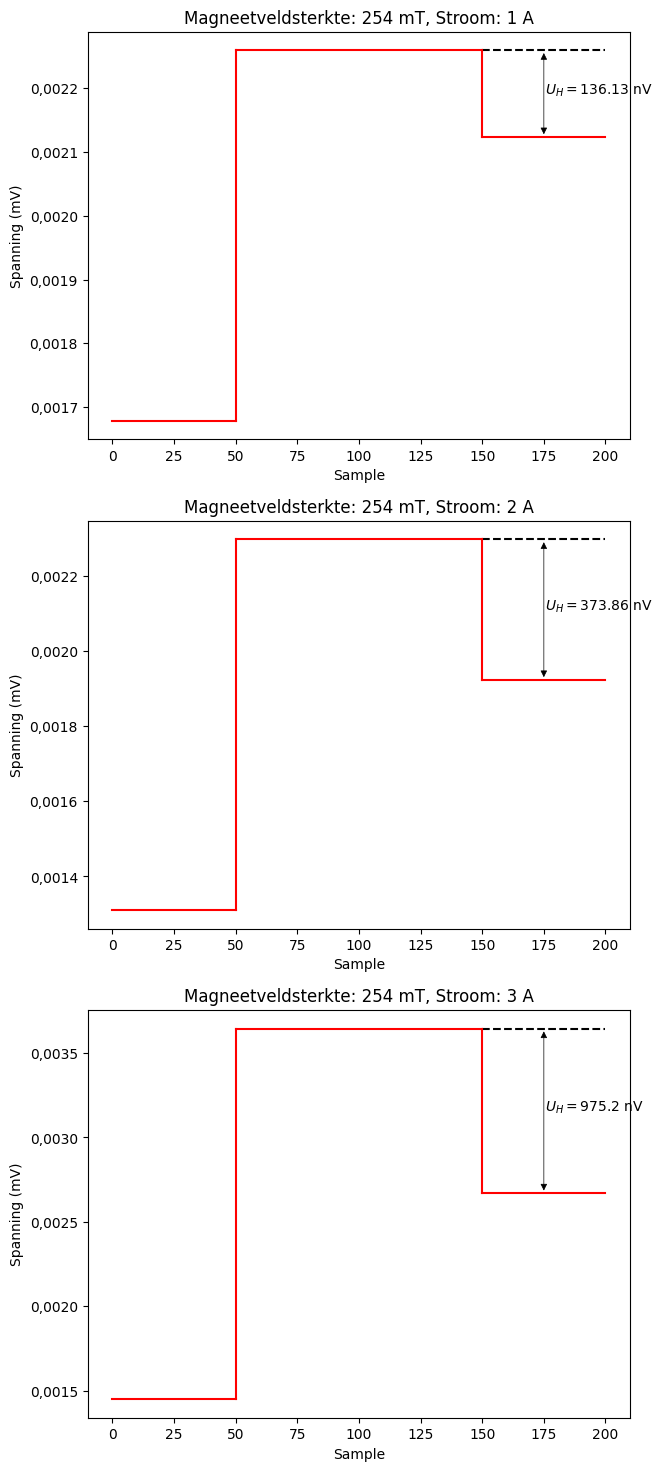

In [15]:
fig, ax = plt.subplots(nrows=3,ncols=1,figsize=(7,18))

for i in range(3):
    plot_hall_mean(ax[i], U_1[i], U_2[i], U_3[i], [0,50], [50, 150], [150, 200], B, I[i])

Deze grafieken komen niet overeen met de realiteit, ze dienen als een hulpmiddel.

In [16]:
# parameters voor koper opstelling:

b = 2 # cm
h = 0.34 # mm
l2 = 10 # cm

e = 1.602176620*10**(-19)


In [17]:
n1 = []

for i in range(3):
    n1.append(get_n_with_std([I[i], 0.01], [B*(10**-3), 0.05*(10**-3)], [U_H[i]*(10**-3), U_H_STD[i]*(10**-3)], [b*(10**-2), 0.1*(10**-2)], [h*(10**-3), 0.005*(10**-3)], [l2*(10**-2), 0.1*(10**-2)], e))

print(n1)

[(1.712577785436858e+23, 1.5346595019315684e+23), (1.2471909685418867e+23, 1.1743227999440384e+23), (7.172027907723649e+22, 1.3331919425571217e+22)]


Of dus:

$n_{I1} = (1,7 \pm 1,6) \cdot 10^{23}~\mathrm{cm}^{-3}$; $n_{I2} = (1,2 \pm 1,2) \cdot 10^{23}~\mathrm{cm}^{-3}$; $n_{I3} = (7,2 \pm 1,4) \cdot 10^{22}~\mathrm{cm}^{-3}$  

#### B = 220,8 mT (de fout is te groot)

In [18]:
B = 220.8
I = np.array([1, 2, 3])

U_1 = np.zeros(3)
U_1_STD = np.zeros(3)

U_2 = np.zeros(3)
U_2_STD = np.zeros(3)

U_3 = np.zeros(3)
U_3_STD = np.zeros(3)

U_H = np.zeros(3)
U_H_STD = np.zeros(3)


for i in range(3):
    x = read_data(file(220,A[i]))
    N = len(x)
    t = Ts*np.arange(N)
    
    U_1[i] = np.mean(x[np.logical_and(0 < t, t < 40)])
    U_1_STD[i] = np.std(x[np.logical_and(0 < t, t < 40)])

    U_2[i] = np.mean(x[np.logical_and(100 < t, t < 150)])
    U_2_STD[i] = np.std(x[np.logical_and(100 < t, t < 150)])

    if i != 3:
        U_3[i] = np.mean(x[np.logical_and(200 < t, t < 250)])
        U_3_STD[i] = np.std(x[np.logical_and(200 < t, t < 250)])
    else:
        U_3[i] = np.mean(x[np.logical_and(275 < t, t < 330)])
        U_3_STD[i] = np.std(x[np.logical_and(275 < t, t < 330)])
     
    U_H[i] = U_2[i] - U_3[i] #np.mean(x[np.logical_and(0 < t, t < 50)])
    U_H_STD[i] = (U_2_STD[i] ** 2 + U_3_STD[i] ** 2) ** 0.5

In [19]:
print(U_H)
print(U_H_STD)

[-6.09181633e-05 -2.51071429e-05 -1.59448163e-04]
[0.00010046 0.00081442 0.00016237]


Dus we zien dat: 

$U_{H1} = (-0,00006 \pm 0,00011)$ mV; $U_{H2} = (-0,00003 \pm 0,00082)$ mV; $U_{H3} = (-0,00002 \pm 0,00017)$ mV.

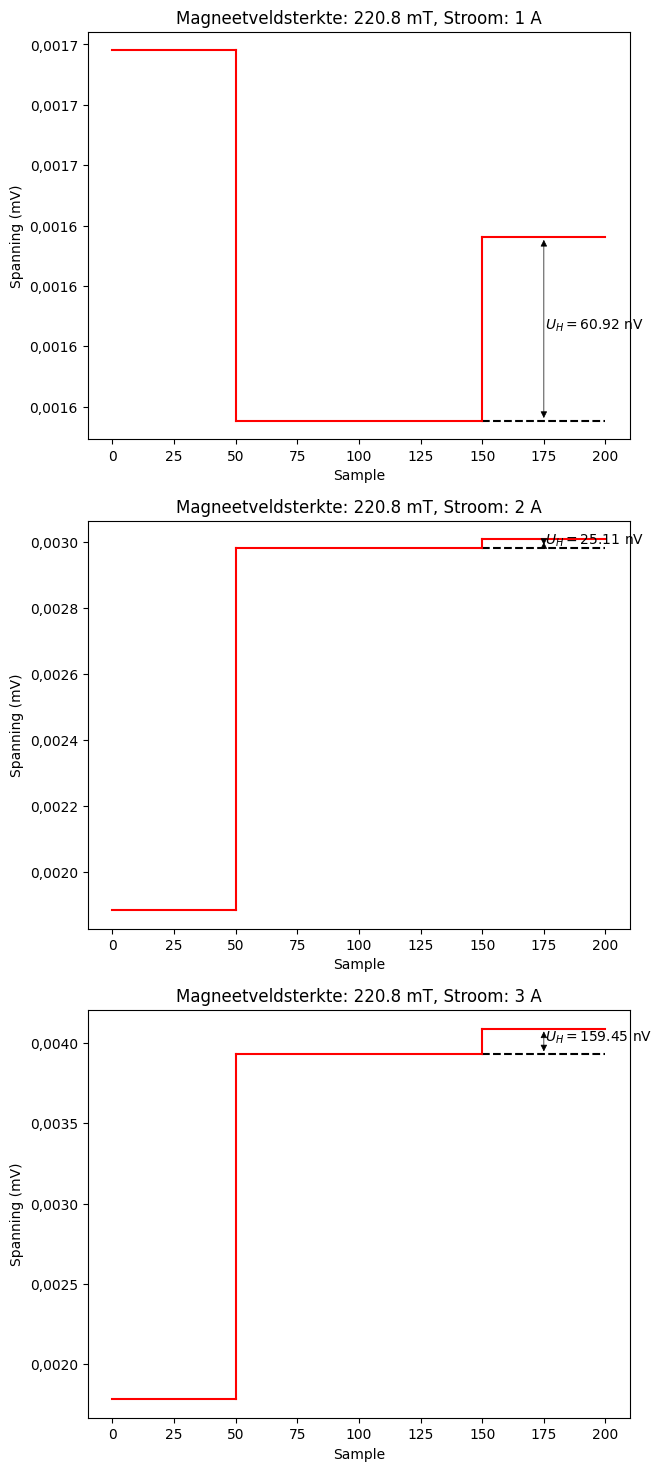

In [20]:
fig, ax = plt.subplots(nrows=3,ncols=1,figsize=(7,18))

for i in range(3):
    plot_hall_mean(ax[i], U_1[i], U_2[i], U_3[i], [0,50], [50, 150], [150, 200], B, I[i])

In [21]:
n2 = []

for i in range(3):
    n2.append(get_n_with_std([I[i], 0.01], [B*(10**-3), 0.05*(10**-3)], [U_H[i]*(10**-3), U_H_STD[i]*(10**-3)], [b*(10**-2), 0.1*(10**-2)], [h*(10**-3), 0.005*(10**-3)], [l2*(10**-2), 0.1*(10**-2)], e))

print(n2)

[(3.326848053706869e+23, 5.4890159787476954e+23), (1.6144049049923209e+24, 5.236791711744091e+25), (3.813129020947677e+23, 3.888230994509475e+23)]


Of dus:

$n_{I1} = (3,3 \pm 5,5) \cdot 10^{23}~\mathrm{cm}^{-3}$; $n_{I2} = (2 \pm 53) \cdot 10^{24}~\mathrm{cm}^{-3}$; $n_{I3} = (3,8 \pm 3,9) \cdot 10^{23}~\mathrm{cm}^{-3}$  

#### B = 175.5 mT

In [22]:
B = 175.5
I = np.array([1, 2, 3])

U_1 = np.zeros(3)
U_1_STD = np.zeros(3)

U_2 = np.zeros(3)
U_2_STD = np.zeros(3)

U_3 = np.zeros(3)
U_3_STD = np.zeros(3)

U_H = np.zeros(3)
U_H_STD = np.zeros(3)


for i in range(3):
    x = read_data(file(175,A[i]))
    N = len(x)
    t = Ts*np.arange(N)
    
    U_1[i] = np.mean(x[np.logical_and(60 < t, t < 100)])
    U_1_STD[i] = np.std(x[np.logical_and(60 < t, t < 100)])

    if i != 0:
        U_2[i] = np.mean(x[np.logical_and(120 < t, t < 200)])
        U_2_STD[i] = np.std(x[np.logical_and(120 < t, t < 200)])
    else:
        U_2[i] = np.mean(x[np.logical_and(200 < t, t < 260)])
        U_2_STD[i] = np.std(x[np.logical_and(200 < t, t < 260)])

    if i == 0:
        U_3[i] = np.mean(x[np.logical_and(320 < t, t < 350)])
        U_3_STD[i] = np.std(x[np.logical_and(320 < t, t < 350)])
    elif i == 1:
        U_3[i] = np.mean(x[np.logical_and(400 < t, t < 450)])
        U_3_STD[i] = np.std(x[np.logical_and(400 < t, t < 450)])
    else:
        U_3[i] = np.mean(x[np.logical_and(300 < t, t < 360)])
        U_3_STD[i] = np.std(x[np.logical_and(300 < t, t < 360)])
     
    U_H[i] = U_2[i] - U_3[i]
    U_H_STD[i] = (U_2_STD[i] ** 2 + U_3_STD[i] ** 2) ** 0.5

In [23]:
print(U_H)
print(U_H_STD)

[-0.00032523  0.0003628  -0.00040248]
[0.00315584 0.00010225 0.00018215]


Dus we zien dat: 

$U_{H1} = (-0,0003 \pm 0,0032)$ mV; $U_{H2} = (0,00036 \pm 0,00011)$ mV; $U_{H3} = (-0,00041 \pm 0,00019)$ mV.

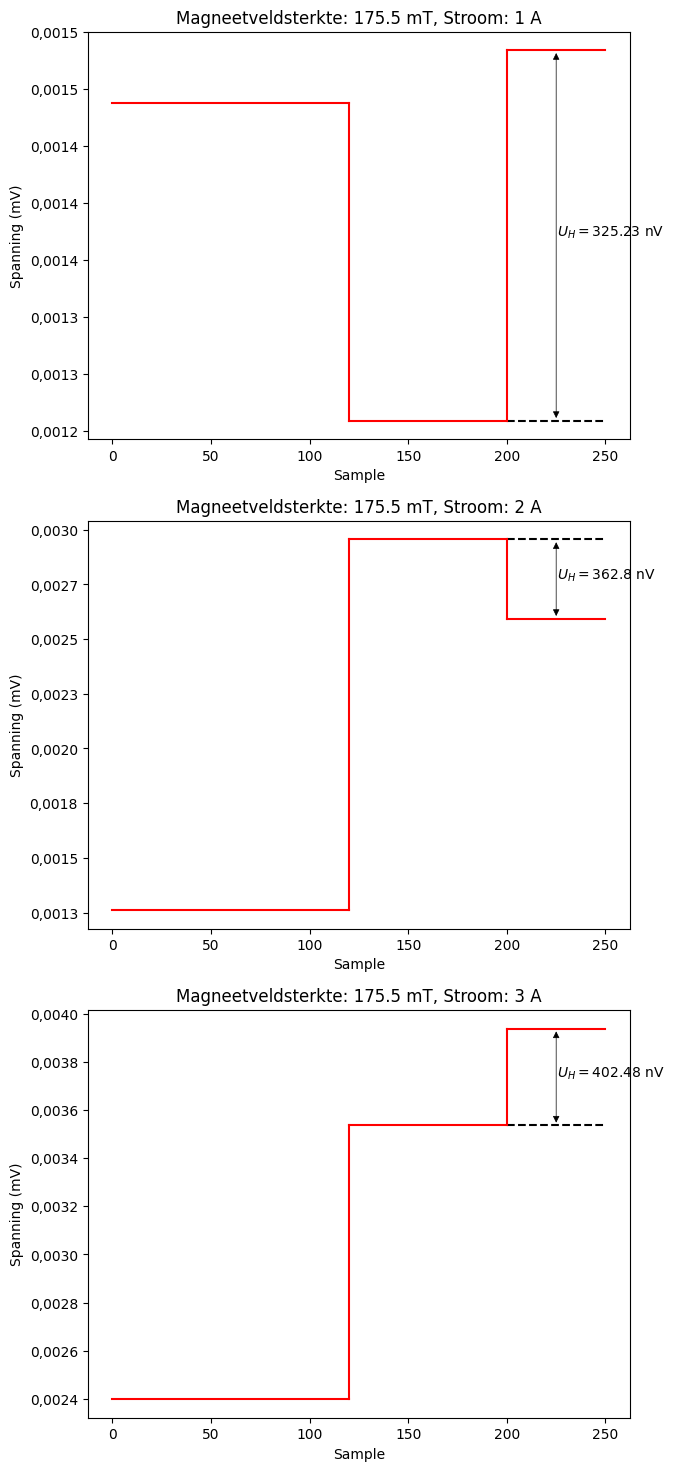

In [24]:
fig, ax = plt.subplots(nrows=3,ncols=1,figsize=(7,18))

for i in range(3):
    plot_hall_mean(ax[i], U_1[i], U_2[i], U_3[i], [0,120], [120, 200], [200, 250], B, I[i])

In [25]:
n3 = []

for i in range(3):
    n3.append(get_n_with_std([I[i], 0.01], [B*(10**-3), 0.05*(10**-3)], [U_H[i]*(10**-3), U_H_STD[i]*(10**-3)], [b*(10**-2), 0.1*(10**-2)], [h*(10**-3), 0.005*(10**-3)], [l2*(10**-2), 0.1*(10**-2)], e))

print(n3)

[(4.952929320356917e+22, 4.806051847642744e+23), (8.880088938908945e+22, 2.5469944399607724e+22), (1.200711933201339e+23, 5.4715580008991015e+22)]


Of dus:

$n_{I1} = (5 \pm 49) \cdot 10^{22}~\mathrm{cm}^{-3}$; $n_{I2} = (8,9 \pm 2,6) \cdot 10^{22}~\mathrm{cm}^{-3}$; $n_{I3} = (12,0 \pm 5,5) \cdot 10^{22}~\mathrm{cm}^{-3}$  

#### Gemiddelde

Het gewogen gemiddelde wordt gegeven door

$\hat{\mu} = \frac{\sum (x_i/\sigma _i ^2)}{\sum (1/ \sigma _i ^2)}$

met

$\sigma (\hat{\mu}) =  \sqrt{\frac{1}{\sum \sigma _i ^{-2}}}$

In [26]:
def mean_density(n1,n2,n3):

    lst = n1 + n2 + n3
    weighted_sum = 0
    weights = 0

    for density in lst:
        weighted_sum += density[0]/(density[1])**2
        weights += 1/(density[1])**2
    
    mean_density = weighted_sum/weights
    mean_density_std = 1/np.sqrt(weights)

    return mean_density,mean_density_std

mean_density_K ,mean_density_std = mean_density(n1,n2,n3)

print(mean_density_K ,mean_density_std )


7.871391191828087e+22 1.1447496303343888e+22


We bekomen voor koper een waarde $n = (7,87 \pm 1,15) \cdot 10^{22}~\mathrm{cm}^{-3}$

Waarde van wikepedia: $8.47\times 10^{22}$ 1/$cm^3$

### 2. Tantaal

#### Hall spannig

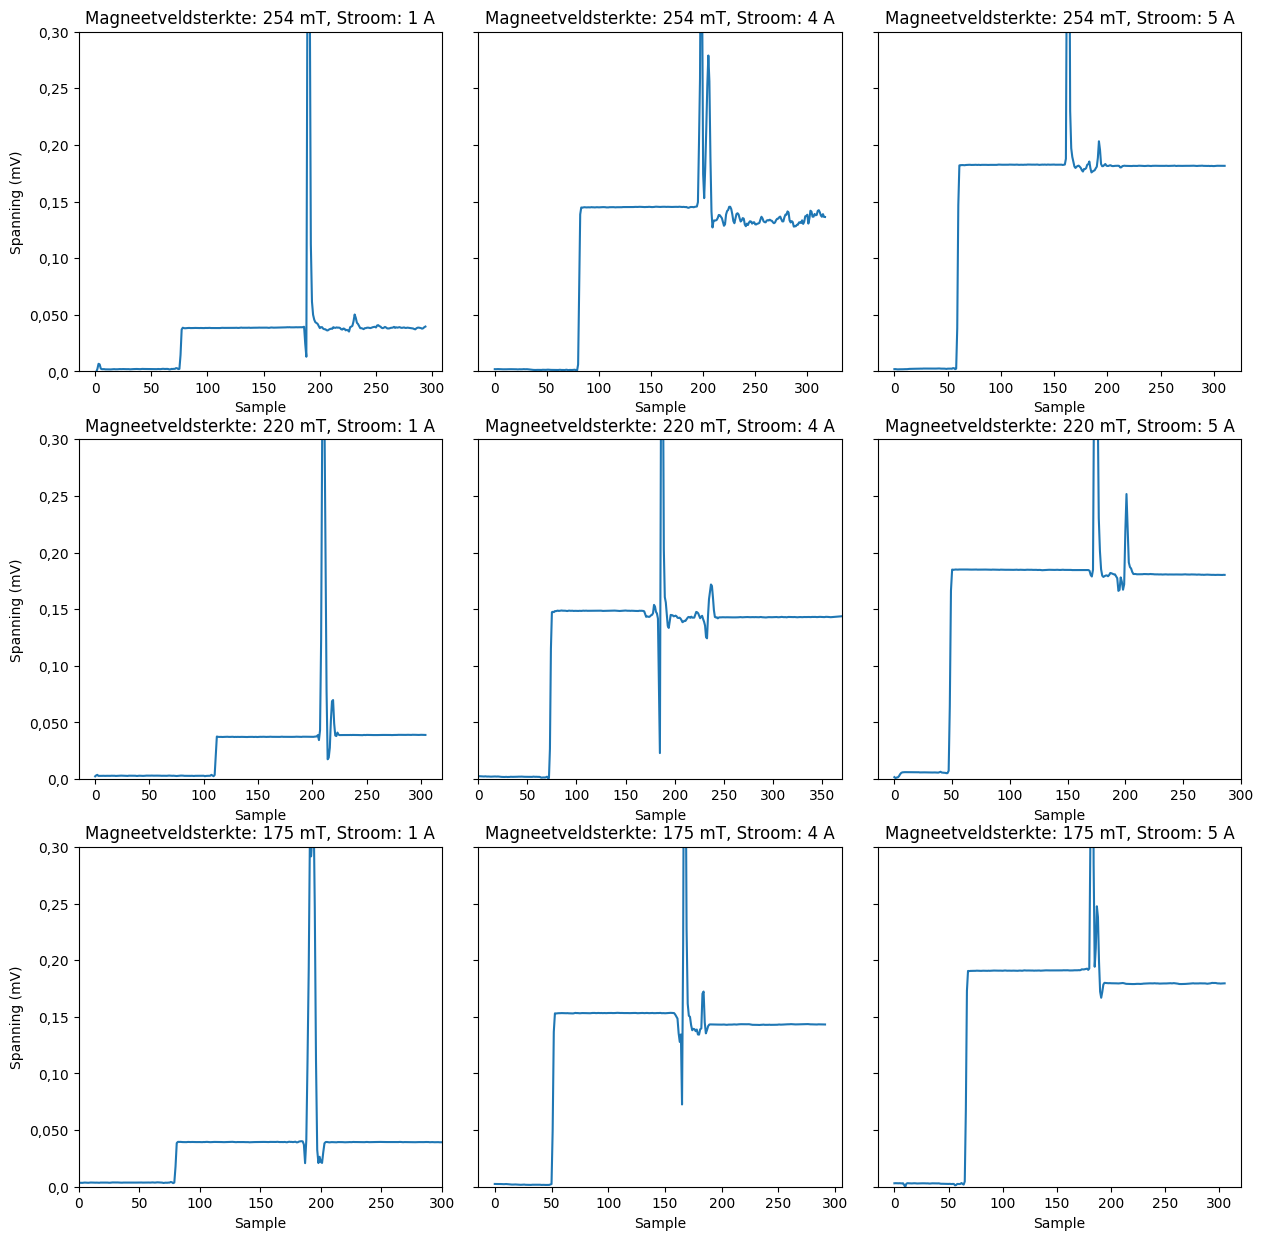

In [39]:
b = 2 # cm
h = 0.09 # mm
l2 = 10 # cm

B = [254,220,175] # mT
A = np.array([1,4,5]) # A
Vlim = [0.1,0.2,0.3]

fig, ax = plt.subplots(nrows=3,ncols=3,figsize=(15,15),sharey=True)
plt.subplots_adjust(wspace=0.1)

for i in range(3):
    for j in range(3):

        x = read_data(file(B[j],A[i],metal='T'))
        N = len(x)
        t = Ts*np.arange(N)
        plot_hall(ax[j,i],t,x,B[j],A[i])
        ax[j,i].set_ylim(0,Vlim[i])
        if i == 0 and j == 2:
            ax[j,i].set_xlim(0,300)
        if i == 1 and j == 1:
            ax[j,i].set_xlim(0,370)
        if i > 0:
            ax[j,i].set_ylabel(None)

#### B = 254 mT

In [28]:
B = 254
I = np.array([1, 4, 5])

U_1 = np.zeros(3)
U_1_STD = np.zeros(3)

U_2 = np.zeros(3)
U_2_STD = np.zeros(3)

U_3 = np.zeros(3)
U_3_STD = np.zeros(3)

U_H = np.zeros(3)
U_H_STD = np.zeros(3)


for i in range(3):
    x = read_data(file(254,A[i], metal='T'))
    N = len(x)
    t = Ts*np.arange(N)
    
    U_1[i] = np.mean(x[np.logical_and(0 < t, t < 50)])
    U_1_STD[i] = np.std(x[np.logical_and(0 < t, t < 50)])

    U_2[i] = np.mean(x[np.logical_and(100 < t, t < 150)])
    U_2_STD[i] = np.std(x[np.logical_and(100 < t, t < 150)])

    if i != 2:
        U_3[i] = np.mean(x[np.logical_and(250 < t, t < 300)])
        U_3_STD[i] = np.std(x[np.logical_and(250 < t, t < 300)])
    else:
        U_3[i] = np.mean(x[np.logical_and(200 < t, t < 300)])
        U_3_STD[i] = np.std(x[np.logical_and(200 < t, t < 300)])
     
    U_H[i] = U_2[i] - U_3[i] #np.mean(x[np.logical_and(0 < t, t < 50)])
    U_H_STD[i] = (U_2_STD[i] ** 2 + U_3_STD[i] ** 2) ** 0.5

In [29]:
print(U_H)
print(U_H_STD)

[-0.0001434   0.01193772  0.00105512]
[0.00071319 0.0029711  0.00022988]


Dus we zien dat: 

$U_{H1} = (-0,00014 \pm 0,00072)$ mV; $U_{H2} = (0,0119 \pm 0,0030)$ mV; $U_{H3} = (0,00105 \pm 0,00012)$ mV.

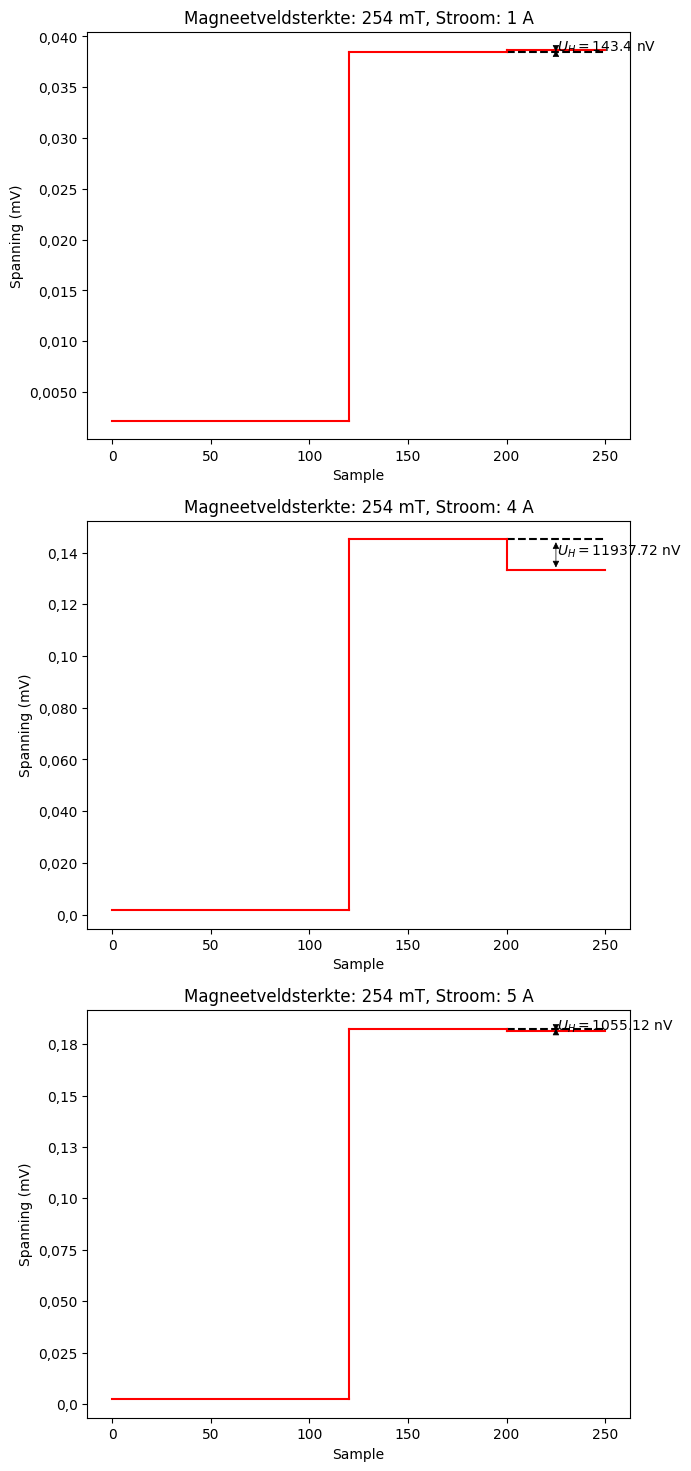

In [30]:
fig, ax = plt.subplots(nrows=3,ncols=1,figsize=(7,18))

for i in range(3):
    plot_hall_mean(ax[i], U_1[i], U_2[i], U_3[i], [0,120], [120, 200], [200, 250], B, I[i])

In [31]:
n1_T = []

for i in range(3):
    n1_T.append(get_n_with_std([I[i], 0.01], [B*(10**-3), 0.05*(10**-3)], [U_H[i]*(10**-3), U_H_STD[i]*(10**-3)], [b*(10**-2), 0.1*(10**-2)], [h*(10**-3), 0.005*(10**-3)], [l2*(10**-2), 0.1*(10**-2)], e))

print(n1_T)

[(6.141988158325624e+23, 3.0550682923233885e+24), (2.951138372620133e+22, 7.674992169086827e+21), (4.173681595967322e+23, 9.622696372918775e+22)]


Of dus:

$n_{I1} = (6 \pm 31) \cdot 10^{23}~\mathrm{cm}^{-3}$; $n_{I2} = (2,95 \pm 0,77) \cdot 10^{22}~\mathrm{cm}^{-3}$; $n_{I3} = (4,17 \pm 0,97) \cdot 10^{23}~\mathrm{cm}^{-3}$  

#### B = 220,8 mT

In [32]:
B = 220.8
I = np.array([1, 4, 5])

U_1 = np.zeros(3)
U_1_STD = np.zeros(3)

U_2 = np.zeros(3)
U_2_STD = np.zeros(3)

U_3 = np.zeros(3)
U_3_STD = np.zeros(3)

U_H = np.zeros(3)
U_H_STD = np.zeros(3)


for i in range(3):
    x = read_data(file(220,A[i], metal='T'))
    N = len(x)
    t = Ts*np.arange(N)
    
    U_1[i] = np.mean(x[np.logical_and(0 < t, t < 45)])
    U_1_STD[i] = np.std(x[np.logical_and(0 < t, t < 45)])

    if i == 0:
        U_2[i] = np.mean(x[np.logical_and(125 < t, t < 200)])
        U_2_STD[i] = np.std(x[np.logical_and(125 < t, t < 200)])
    elif i == 1:
        U_2[i] = np.mean(x[np.logical_and(90 < t, t < 150)])
        U_2_STD[i] = np.std(x[np.logical_and(90 < t, t < 150)])
    else:
        U_2[i] = np.mean(x[np.logical_and(50 < t, t < 150)])
        U_2_STD[i] = np.std(x[np.logical_and(50 < t, t < 150)])

    if i == 1:
        U_3[i] = np.mean(x[np.logical_and(280 < t, t < 350)])
        U_3_STD[i] = np.std(x[np.logical_and(280 < t, t < 350)])
    elif i == 0:
        U_3[i] = np.mean(x[np.logical_and(250 < t, t < 300)])
        U_3_STD[i] = np.std(x[np.logical_and(250 < t, t < 300)])
    elif i == 2:
        U_3[i] = np.mean(x[np.logical_and(225 < t, t < 275)])
        U_3_STD[i] = np.std(x[np.logical_and(225 < t, t < 275)])
     
    U_H[i] = U_2[i] - U_3[i] #np.mean(x[np.logical_and(0 < t, t < 50)])
    U_H_STD[i] = (U_2_STD[i] ** 2 + U_3_STD[i] ** 2) ** 0.5

In [33]:
print(U_H)
print(U_H_STD)

[-0.00169216  0.00558888  0.00422441]
[0.00010899 0.00014542 0.00018418]


Dus we zien dat: 

$U_{H1} = (-0,00169 \pm 0,00011)$ mV; $U_{H2} = (0,0056 \pm 0,00015)$ mV; $U_{H3} = (0,0042 \pm 0,00019)$ mV.

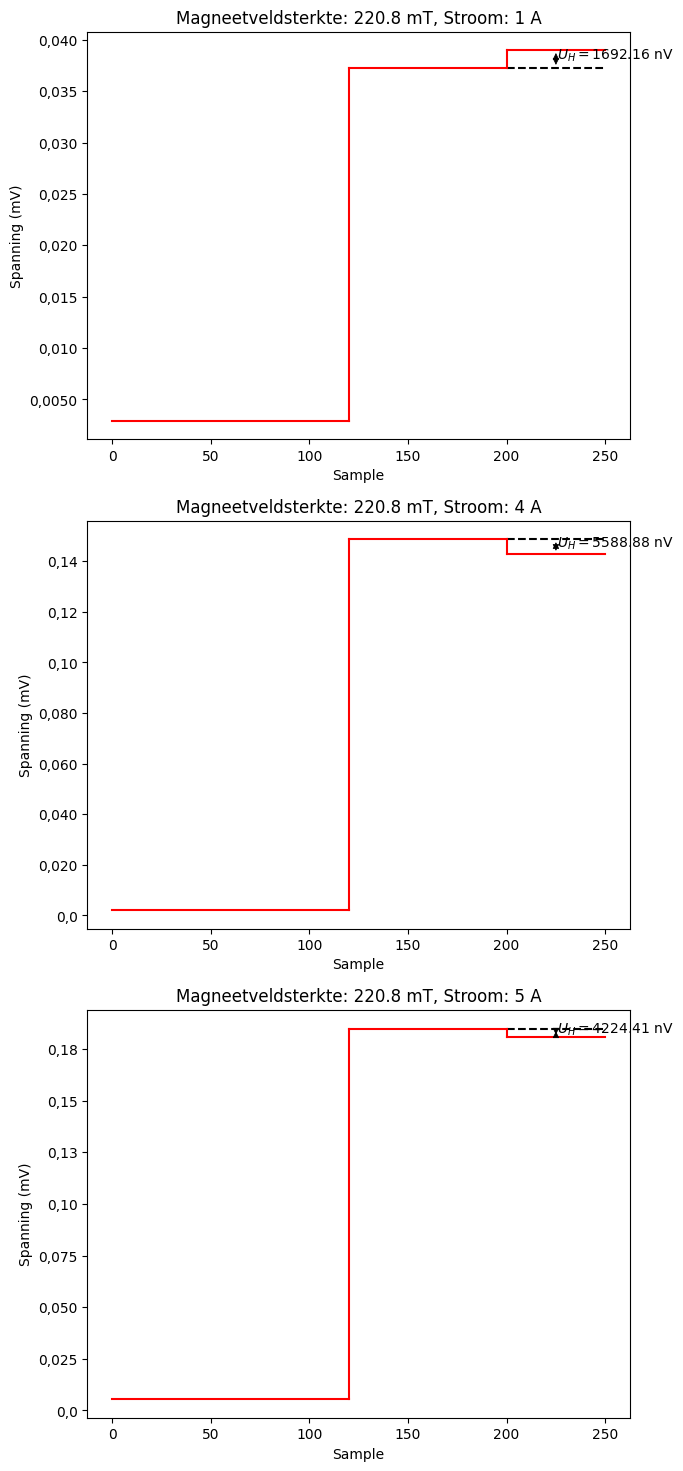

In [34]:
fig, ax = plt.subplots(nrows=3,ncols=1,figsize=(7,18))

for i in range(3):
    plot_hall_mean(ax[i], U_1[i], U_2[i], U_3[i], [0,120], [120, 200], [200, 250], B, I[i])

In [35]:
n2_T = []

for i in range(3):
    n2_T.append(get_n_with_std([I[i], 0.01], [B*(10**-3), 0.05*(10**-3)], [U_H[i]*(10**-3), U_H_STD[i]*(10**-3)], [b*(10**-2), 0.1*(10**-2)], [h*(10**-3), 0.005*(10**-3)], [l2*(10**-2), 0.1*(10**-2)], e))

print(n2_T)

[(4.524532125539382e+22, 4.509789576513637e+21), (5.4796290309361276e+22, 4.373336648493306e+21), (9.061923107519016e+22, 7.895480653521691e+21)]


Of dus:

$n_{I1} = (4,52 \pm 0,46) \cdot 10^{22}~\mathrm{cm}^{-3}$; $n_{I2} = (5,48 \pm 0,44) \cdot 10^{22}~\mathrm{cm}^{-3}$; $n_{I3} = (9,06 \pm 0,79) \cdot 10^{22}~\mathrm{cm}^{-3}$  

#### B = 175.5 mT

In [36]:
B = 175.5
I = np.array([1, 4, 5])

U_1 = np.zeros(3)
U_1_STD = np.zeros(3)

U_2 = np.zeros(3)
U_2_STD = np.zeros(3)

U_3 = np.zeros(3)
U_3_STD = np.zeros(3)

U_H = np.zeros(3)
U_H_STD = np.zeros(3)


for i in range(3):
    x = read_data(file(175,A[i], metal='T'))
    N = len(x)
    t = Ts*np.arange(N)
    
    U_1[i] = np.mean(x[np.logical_and(0 < t, t < 45)])
    U_1_STD[i] = np.std(x[np.logical_and(0 < t, t < 45)])

    if i == 1:
        U_2[i] = np.mean(x[np.logical_and(55 < t, t < 150)])
        U_2_STD[i] = np.std(x[np.logical_and(55 < t, t < 150)])
    elif i == 2:
        U_2[i] = np.mean(x[np.logical_and(75 < t, t < 175)])
        U_2_STD[i] = np.std(x[np.logical_and(75 < t, t < 175)])
    else:
        U_2[i] = np.mean(x[np.logical_and(75 < t, t < 175)])
        U_2_STD[i] = np.std(x[np.logical_and(75 < t, t < 175)])
 
    if i == 1:
        U_3[i] = np.mean(x[np.logical_and(200 < t, t < 300)])
        U_3_STD[i] = np.std(x[np.logical_and(200 < t, t < 300)])
    elif i == 2:
        U_3[i] = np.mean(x[np.logical_and(200 < t, t < 300)])
        U_3_STD[i] = np.std(x[np.logical_and(200 < t, t < 300)])
    else:
        U_3[i] = np.mean(x[np.logical_and(200 < t, t < 300)])
        U_3_STD[i] = np.std(x[np.logical_and(200 < t, t < 300)])
     
    U_H[i] = U_2[i] - U_3[i] #np.mean(x[np.logical_and(0 < t, t < 50)])
    U_H_STD[i] = (U_2_STD[i] ** 2 + U_3_STD[i] ** 2) ** 0.5

In [37]:
print(U_H)
print(U_H_STD)

[-0.00130868  0.0100703   0.01148351]
[0.00759993 0.00022474 0.00033249]


Dus we zien dat: 

$U_{H1} = (-0,0013 \pm 0,0076)$ mV; $U_{H2} = (0,01007 \pm 0,00023)$ mV; $U_{H3} = (0,01149 \pm 0,00034)$ mV.

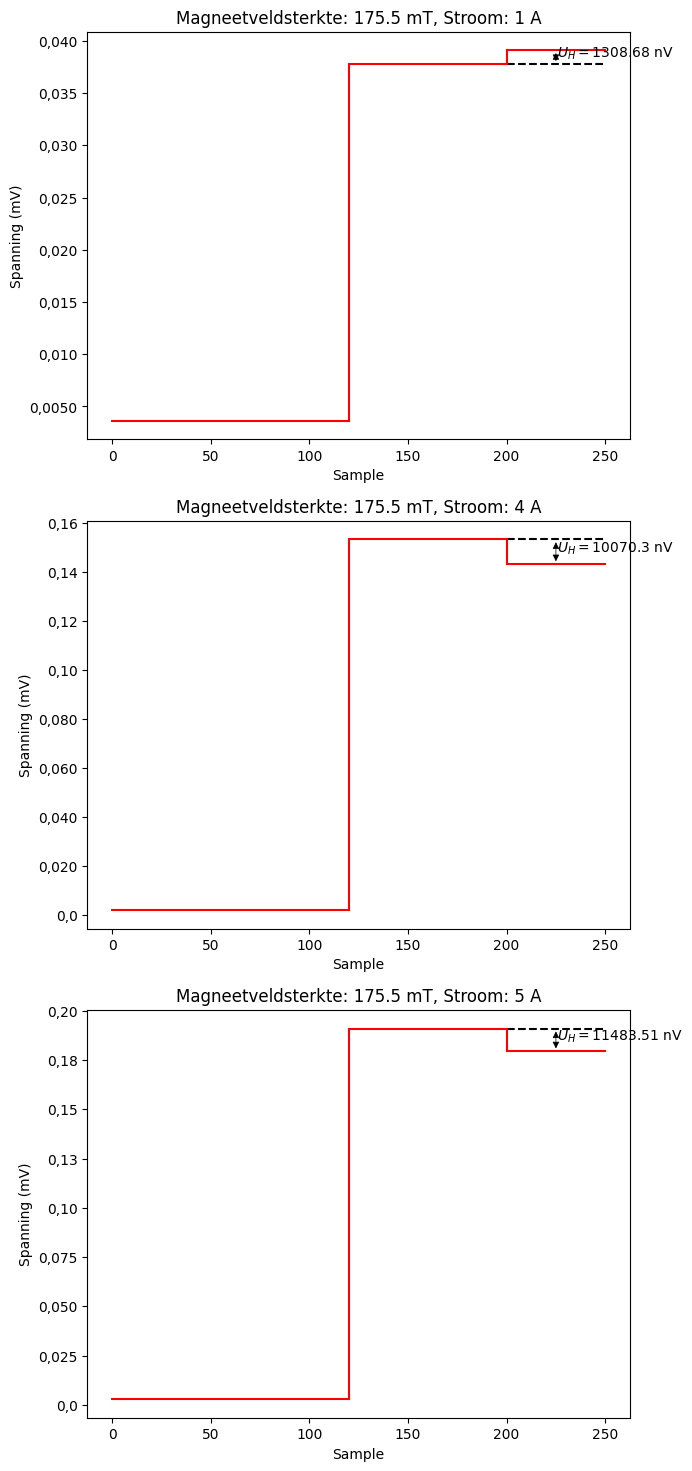

In [38]:
fig, ax = plt.subplots(nrows=3,ncols=1,figsize=(7,18))

for i in range(3):
    plot_hall_mean(ax[i], U_1[i], U_2[i], U_3[i], [0,120], [120, 200], [200, 250], B, I[i])

In [39]:
n3_T = []

for i in range(3):
    n3_T.append(get_n_with_std([I[i], 0.01], [B*(10**-3), 0.05*(10**-3)], [U_H[i]*(10**-3), U_H_STD[i]*(10**-3)], [b*(10**-2), 0.1*(10**-2)], [h*(10**-3), 0.005*(10**-3)], [l2*(10**-2), 0.1*(10**-2)], e))

print(n3_T)

[(4.650092569178712e+22, 2.700697052778121e+23), (2.4171948014646646e+22, 1.901889748686913e+21), (2.649655389080509e+22, 2.1409516995132834e+21)]


Of dus:

$n_{I1} = (5 \pm 28) \cdot 10^{22}~\mathrm{cm}^{-3}$; $n_{I2} = (2,42 \pm 0,20) \cdot 10^{22}~\mathrm{cm}^{-3}$; $n_{I3} = (2,65 \pm 0,22) \cdot 10^{22}~\mathrm{cm}^{-3}$  

#### Gemiddelde

In [40]:
mean_density_T ,mean_density_std = mean_density(n1_T, n2_T, n3_T)

print(mean_density_T, mean_density_std)


3.1075557883351572e+22 1.2606657581472172e+21


We bekomen voor tantaal een waarde $n = (3,11 \pm 0,13) \cdot 10^{22}~\mathrm{cm}^{-3}$

In [41]:
# parameters voor tantaal opstelling:

b = 2 # cm
h = 0.09 # mm
l2 = 10 # cm

e = 1.602176620*10**(-19)

# berekening voor 254 mT en 4A
I = 4
B = 254

x = read_data(file(B,I,metal='T'))
t = Ts*np.arange(len(x))

v = np.mean(x[np.logical_and(100 < t, t < 150)]) - np.mean(x[np.logical_and(230 < t, t < 300)])
n = l2/(b*h)*1/e*I*B/v*10**(-3)

print(n)

2.9441482560173985e+22


In [44]:
# estimae using Drude model
Navogadro = 6.02214076*10**(23) # mol^-1
Z = 5
rhom = 16.69 # g/cm^3 https://en.wikipedia.org/wiki/Tantalum
ma = 180.9479 # g/mol (molar mass) https://www.chemicalaid.com/tools/molarmass.php?formula=Ta&hl=en#:~:text=The%20molar%20mass%20and%20molecular,weight%20of%20Ta%20is%20180.948.

n = Navogadro*Z*rhom/ma
print(n)

2.777305768245998e+23


Beschouw de waarde voor "thallium": $1.05\times 10^{23}$ 1/$cm^3$ wat zeer dicht staat bij ons resultaat.